# CNNs - Convolutional Neural Networks

Code examples modified from [https://blog.algorithmia.com/convolutional-neural-nets-in-pytorch]

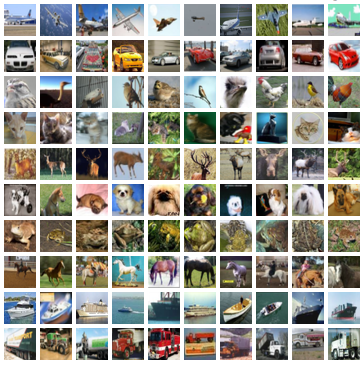

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
seed = 42 # Allows exactly reproducible experiments
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
#The compose function allows for multiple transforms
#transforms.ToTensor() converts our PILImage to a tensor of shape (C x H x W) in the range [0,1]
#transforms.Normalize(mean,std) normalizes a tensor to a (mean, std) for (R, G, B)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./cifardata', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Particular to this dataset.

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 20000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Validation
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [6]:
from torch.autograd import Variable
import torch.nn.functional as F

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1) # Docs at https://pytorch.org/docs/stable/nn.html
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 32, 32) to (18, 16, 16)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18 * 16 *16)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

In [7]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,sampler=train_sampler, num_workers=2)
    return(train_loader)

In [8]:
#Test and validation loaders have constant batch sizes (gradient estimates don't matter), so we can define them directly
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, sampler=test_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler, num_workers=2)

In [9]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate) # Specific to the net parameters
    
    return(loss, optimizer)

In [10]:
import tqdm

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
#     print("===== HYPERPARAMETERS =====")
#     print("batch_size=", batch_size)
#     print("epochs=", n_epochs)
#     print("learning_rate=", learning_rate)
#     print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        t = tqdm.tqdm(train_loader)
        for i, data in enumerate(t, 0):
            
            #Get inputs
            inputs, labels = data
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Update statistics
            #print(dir(loss))
            #print(type(loss))
            #t.set_description('ML (loss=%g)' % dir(loss))
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.item()
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished")

In [11]:
net = SimpleCNN()

# Net initialization less critical because of images as input    

trainNet(net, batch_size=32, n_epochs=1, learning_rate=0.001)

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:51<00:00, 12.19it/s]


Validation loss = 1.33
Training finished


# Assignment:
1. Modify the CNN to use 